In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
plt.style.use('ggplot')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# Load data using sql query

In [5]:
# connect to sqlite
conn = sqlite3.connect('liquor.db')
# make a cursor
cursor = conn.cursor()
# select data and transform it to df
#query = '''SELECT "Vendor name" FROM vendors where "Vendor number"=10;'''
query = '''SELECT * FROM stores  ;


'''
cursor.execute(query)
result = cursor.fetchall()

cursor.close()
conn.close()

In [6]:
df = pd.DataFrame(result,columns = ['StoreID','StoreName','County','CountyID','City','ZipCode','Location','Address','StoreType'])

In [7]:
df.shape

(2448, 9)

In [8]:
df.head()

StoreID                    StoreName       County CountyID         City  \
0     2106  hillstreet news and tobacco   black hawk      7.0  cedar falls   
1     2113               jamboree foods      webster     94.0       gowrie   
2     2130         sycamore convenience   black hawk      7.0     waterloo   
3     2132             spirits and such      fayette     33.0   west union   
4     2152           dugans supermarket  cerro gordo     17.0     rockwell   

  ZipCode                               Location                 Address  \
0   50613           POINT (-92.455796 42.517182)            2217 college   
1   50543            POINT (-94.289457 42.28057)  1119 market st. box 71   
2   50703           POINT (-92.335358 42.497854)            617 sycamore   
3   52175           POINT (-91.807891 42.961269)               100 e elm   
4   50469  POINT (-93.188172 42.986351000000006)           202 4th north   

                      StoreType  
0          Liquor Tobacco Store  
1  Other Grocery or Convenience  
2             Convenience Store  
3          Liquor Tobacco Store  
4                   Supermarket

In [9]:
df = df.replace('missing',np.nan)

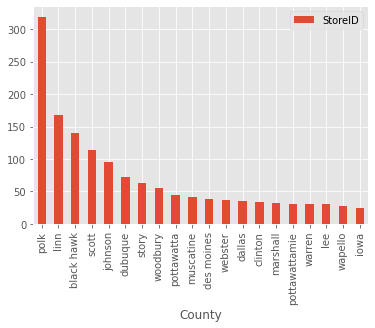

In [10]:
# Check store distribution among county
df.groupby('County').agg({'StoreID':'count'}).sort_values(by = 'StoreID',ascending=False).head(20).plot.bar()

# Hy-vee chain Supermarket case study

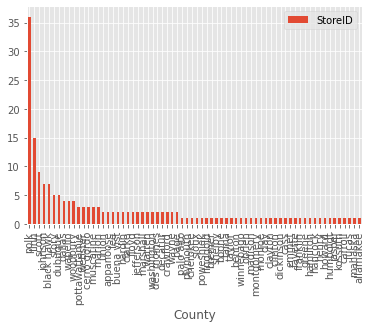

In [11]:
df_hy = df[df.StoreName.str.contains('hy-vee')]
df_hy.groupby('County').agg({'StoreID':'count'}).sort_values(by = 'StoreID',ascending=False).plot.bar()

Seems like polk gets most stores

In [12]:
# Get county population data
county = pd.read_csv('data/County.csv')
county.County = county.County.map(lambda x:x.replace(' County','').lower())

In [13]:
set(df.County.unique()).difference(set(county.County.unique()))

{'buena vist', 'cerro gord', 'el paso', nan, 'obrien', 'pottawatta'}

In [14]:
# make consistent with county name
temp = pd.merge(df[['County','CountyID']],county,on='County',how = 'right').drop_duplicates()
dic = {x:y for x,y in zip(temp.CountyID, temp.County)}
dic[np.nan] = np.nan
df['County'] = [dic[x] for x in df.CountyID]
df.County.nunique()

In [18]:
df1 = pd.merge(df,county.drop('Rank',axis=1),on = 'County',how='left')

In [19]:
df1.shape

(2448, 10)

In [20]:
df1.head()

StoreID                    StoreName       County CountyID         City  \
0     2106  hillstreet news and tobacco   black hawk      7.0  cedar falls   
1     2113               jamboree foods      webster     94.0       gowrie   
2     2130         sycamore convenience   black hawk      7.0     waterloo   
3     2132             spirits and such      fayette     33.0   west union   
4     2152           dugans supermarket  cerro gordo     17.0     rockwell   

  ZipCode                               Location                 Address  \
0   50613           POINT (-92.455796 42.517182)            2217 college   
1   50543            POINT (-94.289457 42.28057)  1119 market st. box 71   
2   50703           POINT (-92.335358 42.497854)            617 sycamore   
3   52175           POINT (-91.807891 42.961269)               100 e elm   
4   50469  POINT (-93.188172 42.986351000000006)           202 4th north   

                      StoreType Population  
0          Liquor Tobacco Store    131,228  
1  Other Grocery or Convenience     35,904  
2             Convenience Store    131,228  
3          Liquor Tobacco Store     19,650  
4                   Supermarket     42,450

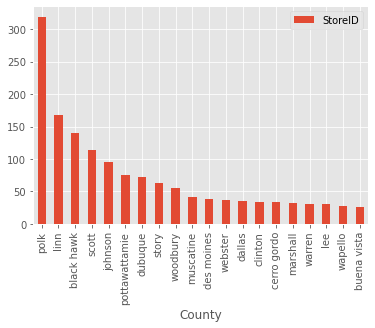

In [21]:
df1.groupby('County').agg({'StoreID':'count'}).sort_values(by='StoreID',ascending=False).head(20).plot.bar()

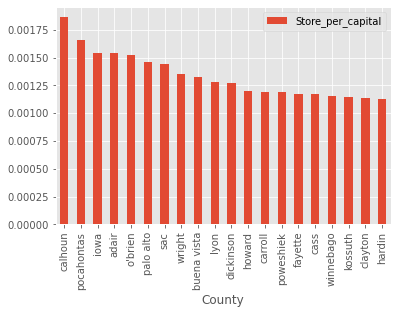

In [26]:
# Store per capital top 10 county bar plot
group = df1.groupby('County').agg({'StoreID':'count','Population':'first'})
group.Population = group.Population.map(lambda x:int(x.replace(',','')))
group['Store_per_capital'] = group.StoreID/group.Population
group.sort_values(by = 'Store_per_capital',ascending=False).head(20).plot.bar(y='Store_per_capital')

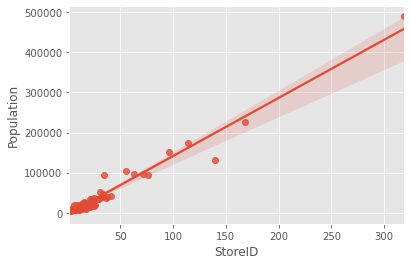

In [31]:
#plt.figure(figsize=(12,12))
sns.regplot(data=group,x='StoreID',y='Population')

Actually the County Population is positive correlated to numbers of stores in the county  

Now let's look at hy-vee supermarket stores analysis of each county

In [27]:
conn = sqlite3.connect("liquor.db")
query = '''
select "Store Name",Date,"Volume Sold","Sale","County","County Number" from transactions
left join stores on transactions."Store Number" == stores."Store Number"
where stores."Store Name" like 'hy-vee%'

'''
tran = pd.read_sql_query(query, conn)
tran.head()

Store Name                 Date  Volume Sold  \
0    hy-vee wine and spirits / hubbell  2012-05-03 00:00:00         21.0   
1     hy-vee food store #2 / iowa city  2015-08-12 00:00:00          1.5   
2  hy-vee wine and spirits / iowa city  2012-09-27 00:00:00          4.5   
3               hy-vee / pleasant hill  2012-03-07 00:00:00         10.5   
4  hy-vee food store #2 / cedar rapids  2014-04-21 00:00:00          9.0   

     Sale   County County Number  
0  123.60     polk          77.0  
1   22.48  johnson          52.0  
2   88.44  johnson          52.0  
3  141.72     polk          77.0  
4  157.44     linn          57.0

In [28]:
dic['missing'] = np.nan
tran['County'] = [dic[x] for x in tran["County Number"]]
tran.Date = pd.to_datetime(tran.Date)

### Check store longevity

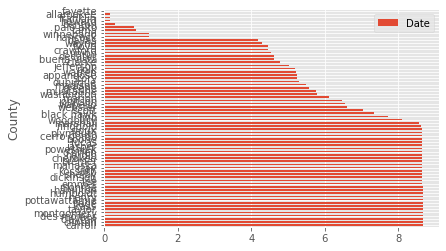

In [37]:
store_hy = tran.groupby('Store Name').agg({'Date':lambda x:(x.max()-x.min()).days/365,'County':'first'})
store_hy.groupby('County').agg({'Date':'mean'}).sort_values(by='Date',ascending=False).plot.barh()

Some county has very stable stores but for some they are not

### check all store count all over 10 years

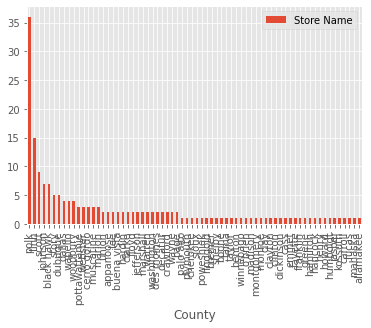

In [39]:
tran.groupby(['County']).agg({'Store Name':'nunique'}).sort_values(by='Store Name',ascending = False).plot.bar()

Polk seems to have most stores among 8 years

### check stores develop and performance over 8 years

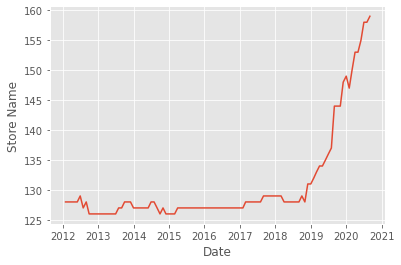

In [41]:
group3 = tran.groupby([pd.Grouper(key ='Date',freq='M')]).agg({'Store Name':'nunique',
                            'Volume Sold':'sum',
                            'Sale':'sum'})
group3 = group3.reset_index()
sns.lineplot(data = group3,x='Date',y='Store Name')

Seems like there is a big increase from 2018-2020

### what about each county

In [42]:
group2 = tran.groupby(['County',pd.Grouper(key ='Date',freq='M')]).agg({'Store Name':'nunique',
                            'Volume Sold':'sum',
                            'Sale':'sum'})
group2 = group2.reset_index()

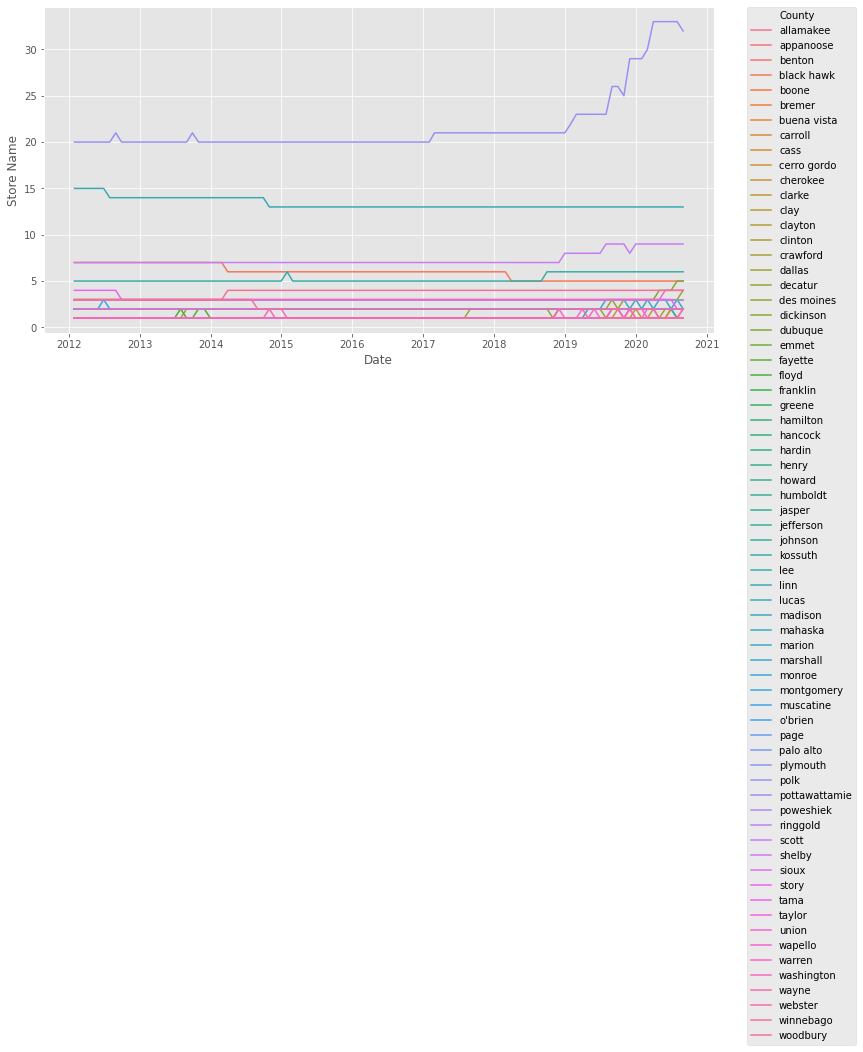

In [43]:
plt.figure(figsize=(12,6))
sns.lineplot(data = group2,x='Date',y='Store Name',hue='County',legend='brief')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Polk seems to contribute most to the big increase, look at polk individually

In [44]:
polk = group2[group2['County']=='polk']

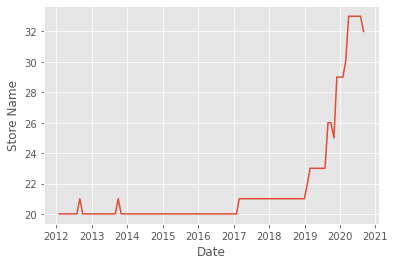

In [45]:
sns.lineplot(data = polk,x='Date',y='Store Name')

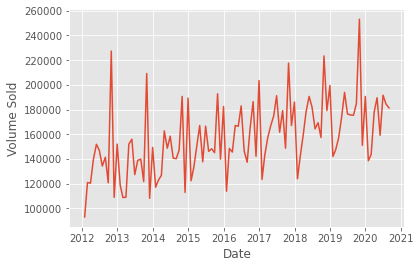

In [47]:
# volume sold over time
sns.lineplot(data = polk,x='Date',y='Volume Sold')

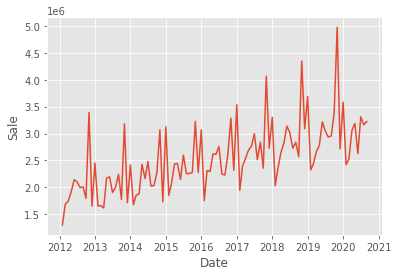

In [48]:
# Sale over time
sns.lineplot(data = polk,x='Date',y='Sale')

### Location

There is some missing location for some stores, but they have the address and county information. So we try to download their location using geopy

In [49]:
# get address for stores which miss location information
missing_loc = df[df.Location.isnull()]
missing_loc = missing_loc[~missing_loc.County.isnull()]
addresses = missing_loc.Address + ',' + missing_loc.County

# use geopy to download the location information
import geopy
from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("504 south highway,pottawattamie")
location
geocode = RateLimiter(locator.geocode, min_delay_seconds=1.5)
locations = [geocode(addr+', Iowa, USA') if type(addr)==str else None for addr in addresses]

# get lat,long for missing data
missing_loc.Location = [x[1] if x!= None else x for x in locations ]
missing_loc = missing_loc[~missing_loc.Location.isnull()]
lat,long = zip(*[(float(x[0]),float(x[1])) for x in missing_loc.Location] )
missing_loc['long'] = long
missing_loc['lat'] = lat
missing_loc = missing_loc.drop(['Location'],axis=1)

# also get lat,long for not missing location stores
loca = df.loc[~df.Location.isnull(),:].copy()
loca['Location'] = loca.Location.map(lambda x : x.replace('POINT (','').replace(')','').strip().split(' '))
long,lat = zip(*[(float(x[0]),float(x[1])) for x in loca.Location] )
loca['long'] = long
loca['lat'] = lat
loca = loca.drop(['Location'],axis=1)
loca = pd.concat([loca,missing_loc],axis=0)
loca = loca[(loca.long>-104)&(loca.lat<44)]
loca['new_long'] = loca['long']*np.cos(42.05)
#loca.to_csv('loca.csv',index_label=False)

In [50]:
loca = pd.read_csv('data/loca.csv')

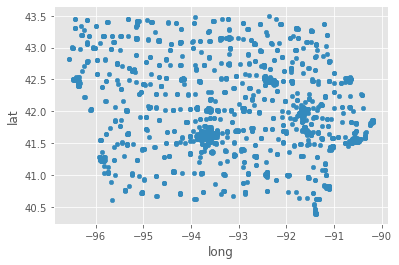

In [51]:
loca.plot.scatter(x='long',y='lat')
#plt.xlim([-98,-85])

In [58]:
samples = loca.loc[:,['new_long','lat']].reset_index(drop=True)
temp = loca.loc[:,['StoreName','long','lat','new_long','County']]

In [60]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
rs = []
eps = np.arange(0.01,0.2,0.01)
min_samples = np.arange(20,400,1)

best_score = 0
best_score_eps = 0
best_score_min_samples = 0

for i in eps:
    for j in min_samples:
        try:
            db = DBSCAN(eps=i,min_samples=j).fit(samples)
            labels = db.labels_
            # filter noise
            dbscan = temp.copy()
            dbscan['y_pred'] = labels
            dbscan = dbscan[dbscan.y_pred>0]
            new_samples = dbscan[['new_long','lat']]
            new_labels = dbscan['y_pred']
            # calculate metrics
            k = metrics.silhouette_score(new_samples,new_labels)
            ratios = len(labels[labels[:]==-1])/len(labels)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            rs.append([i,j,k,ratios,n_clusters])
            if k>best_score:
                best_score = k
                best_score_eps = i
                best_score_min_samples = j
        except:
            db = ''
        
rs = pd.DataFrame(rs,columns=['eps','min_samples','score','ratio','n_clusters'])
            

In [66]:
rs[(rs.score>0.8) &(rs.ratio<0.6)].sort_values(by='score',ascending=False).head(5)
# rs[(rs.score>0) & (rs.n_clusters<100)].sort_values(by='score',ascending=False)

eps  min_samples     score     ratio  n_clusters
1833  0.19           23  0.945772  0.020177           3
1698  0.18           22  0.929200  0.032367           3
1697  0.18           21  0.929200  0.028163           3
43    0.03           28  0.896623  0.594367          11
280   0.06           46  0.881910  0.581337           8

best eps:0.06,min_samples:46

In [52]:
def plot_dbscan(eps,min_samples,include_noise=True):
    y_pred = DBSCAN(eps = eps,min_samples=min_samples).fit_predict(samples)
    dbscan = loca.copy()
    dbscan['y_pred'] = y_pred
    if not include_noise:
        dbscan = dbscan[dbscan.y_pred>=0]
    plt.figure(figsize=(12,6))
    sns.scatterplot(dbscan['long'], dbscan['lat'], hue=dbscan.y_pred,legend='full',palette="Set1")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

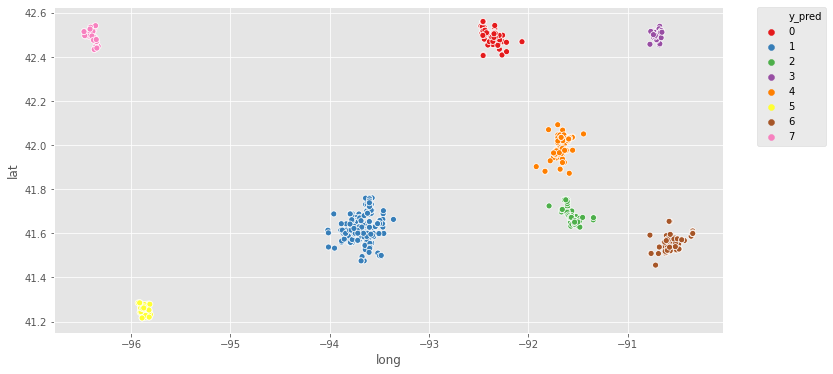

In [59]:
plot_dbscan(0.06,46,False)

Now we want to classify stores into urban and rural area, for those stores which are noise in dbscan we set them rural and for the other we set them uran, we want to compare the stores' longevity of urban and rural area 

In [73]:
conn = sqlite3.connect("liquor.db")
query = '''
SELECT * FROM transactions
'''
tran = pd.read_sql_query(query, conn)
tran.head()

Transaction ID Store Number Vendor Number Item Number  Bottles Sold  \
0   S05371200006         2636         421.0       36978            12   
1   S06418700123         3735          65.0       24453             6   
2   S04376400029         4631         380.0       41989            12   
3   S14098100031         3162          65.0       15248             6   
4   S27255500092         2513         260.0       43410             2   

   Volume Sold    Sale                 Date  
0         21.0  123.60  2012-05-03 00:00:00  
1          1.2   15.84  2012-07-05 00:00:00  
2          9.0  116.88  2012-03-06 00:00:00  
3         10.5   80.28  2013-08-26 00:00:00  
4          1.5   22.48  2015-08-12 00:00:00

In [239]:
# get each store sale information and open time
tran.Date = pd.to_datetime(tran.Date)
long_g = tran.groupby(['Store Number']).agg({'Date': [(lambda x: (max(x)-min(x)).days/365),
                                                      (lambda x: (max(x).year-min(x).year)*12+(max(x).month-min(x).month)),
                                                      (lambda x:max(x).year),
                                                      (lambda x:min(x).year)],
                                           'Volume Sold' : 'sum'
                                  
                                                   })
long_g.columns = ['days','month','max year','min year','volumn sold']
long_g['month'] = long_g['month'].replace(0,1)
long_g = long_g.reset_index()
long_g['volumn_sold_bymonth'] = long_g['volumn sold']/long_g['month']
#long_g.to_csv('long.csv',index_label=False)

In [70]:
long_g = pd.read_csv('data/long.csv')

In [74]:
# get rid of those stores which open less than 3 years ago 
long_g= long_g[~((long_g['max year']==2020) & (long_g['min year'].isin(['2020','2019','2018'])))]
# classify
y_pred = DBSCAN(eps = 0.06,min_samples=46).fit_predict(samples)
dbscan = loca.copy()
dbscan['y_pred'] = y_pred
dbscan['area density'] = ['urban' if x!=-1 else 'rural' for x in dbscan.y_pred]
#dbscan.StoreID = dbscan.StoreID.map(str)
#dbscan.to_csv('location_cluster.csv',index_label=False)

In [76]:
# merge with long_g
final = pd.merge(long_g,dbscan[['StoreID','area density','StoreType']],left_on='Store Number',right_on='StoreID')
#
final.loc[final.StoreType.isin(['Casino','Other Grocery or Convenience']),'StoreType'] = 'Other'

# Compare rural and metro area

In [292]:
final['area density'].value_counts()

rural    1073
urban     808
Name: area density, dtype: int64

In [77]:
final['StoreType'].value_counts()

Convenience Store       702
Liquor Tobacco Store    369
Supermarket             358
Other                   335
Drug Store              117
Name: StoreType, dtype: int64

In [78]:
group_store = final.groupby('area density').agg({ 'StoreType':'value_counts'})#.reset_index()
group_store.columns = ['count']
group_store = group_store.reset_index()

In [365]:
group_store

area density             StoreType  count
0        rural     Convenience Store    387
1        rural                 Other    233
2        rural  Liquor Tobacco Store    211
3        rural           Supermarket    211
4        rural            Drug Store     31
5        urban     Convenience Store    315
6        urban  Liquor Tobacco Store    158
7        urban           Supermarket    147
8        urban                 Other    102
9        urban            Drug Store     86

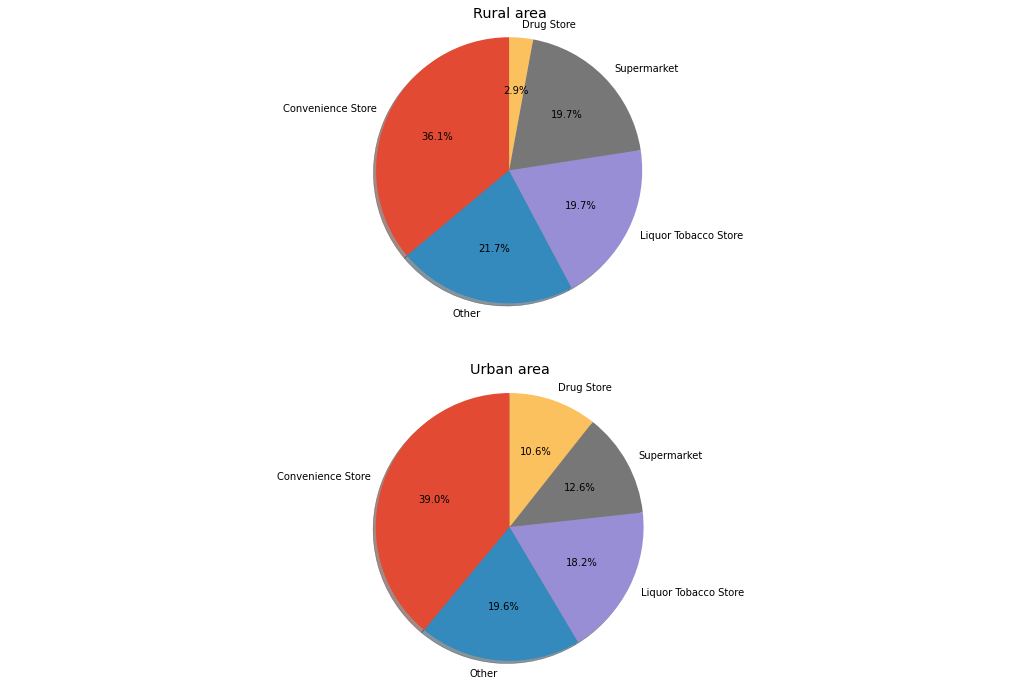

In [79]:
# Pie chart
labels = ['Convenience Store','Other','Liquor Tobacco Store','Supermarket','Drug Store']
sizes1 = group_store['count'][0:5]
sizes2 = group_store['count'][5:10]



fig1, ax1 = plt.subplots(2,1,figsize=(18,12))
ax1[0].pie(sizes1, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1[0].set_title('Rural area')

ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1[1].set_title('Urban area')
plt.show()

In [80]:
final.groupby('area density').agg({'days':'mean', 'volumn_sold_bymonth':'mean'})

days  volumn_sold_bymonth
area density                               
rural         5.651452           827.718293
urban         5.738370          1446.014683

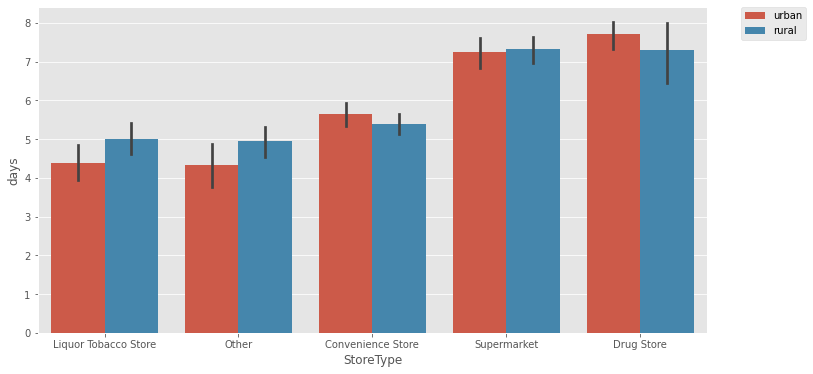

In [81]:
group = final.groupby(['StoreType','area density']).agg({ 'days':'mean','volumn_sold_bymonth':'mean','volumn sold':'mean'}).reset_index()
plt.figure(figsize=(12,6))
#sns.barplot(data=group,x='StoreType',y='days',hue='area density')
sns.barplot(data=final,x='StoreType',y='days',hue='area density')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

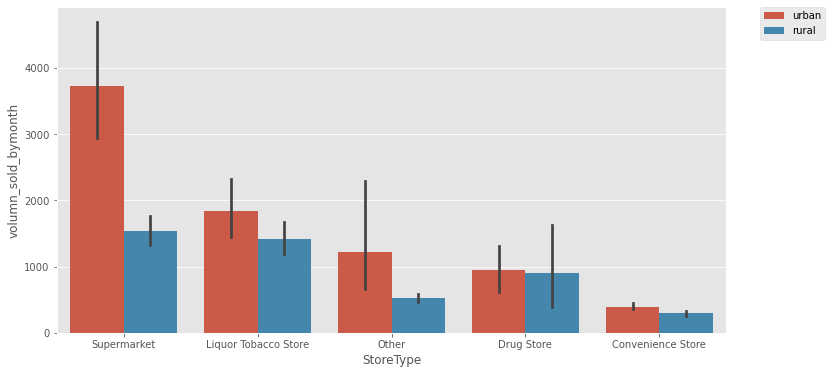

In [351]:
plt.figure(figsize=(12,6))
sns.barplot(data=final,x='StoreType',y='volumn_sold_bymonth',hue='area density',order = ['Supermarket','Liquor Tobacco Store','Other','Drug Store','Convenience Store'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Open a supermarket --- urban area better
for rural area open supermarket or liquir store


# Draw Map

In [89]:
county.Population = county.Population.str.replace(',','').map(int)

In [90]:
def tran_name(x):
    if len(x.split())==2:
        return ' '.join(map(str.capitalize,x.split()))
    elif len(x.split("'"))==2:
        return "'".join(map(str.capitalize,x.split("'")))
    else:
        return x.capitalize()

In [91]:
county.County = county.County.map(tran_name)

In [ ]:
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("Iowa")
location

In [375]:
import folium
# Instantiate a feature group for the incidents in the dataframe
incidents_group = []
color = ['red','blue']
group = ['urban','rural']
for i in range(2):
    incidents = folium.map.FeatureGroup()
    temp = dbscan[dbscan['area density']==group[i]]
    # Loop through the 200 crimes and add each to the incidents feature group
    for lng, lat, in zip(temp.long, temp.lat):
        incidents.add_child(
            folium.CircleMarker(
                [lat, lng],
                radius=0.1, # define how big you want the circle markers to be
                color=color[i],
                fill=True,
                fill_color=color[i],
                fill_opacity=0.6
            )
        )
    incidents_group.append(incidents)


In [376]:
url = 'https://public.opendatasoft.com/explore/dataset/us-county-boundaries/download/?format=geojson&refine.stusab=IA&timezone=America/New_York&lang=en'
url = 'lowa.geojson'
san_geo = f'{url}'
#bins = list(county['Population'].quantile(np.linspace(0,1,10)))
threshold_scale = np.linspace(county['Population'].min(),
                              county['Population'].max(),
                              10, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
m = folium.Map(location=[41.9216734, -93.3122705], zoom_start=8)
folium.Choropleth(
    geo_data=san_geo,
    data=county,
    columns=['County','Population'],
    key_on='feature.properties.name',
    #fill_color='red',
    fill_color='YlGn',
    threshold_scale=threshold_scale,
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True,
    legend_name='Population',
    #bins=bins
).add_to(m)
for i in range(2):
    m.add_child(incidents_group[i])
m
